# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов.  
  
В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов

**Тариф «Смарт»**  

* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
 2. сообщение: 3 рубля;
 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**  

* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: 
 1. минута разговора: 1 рубль; 
 2. сообщение: 1 рубль; 
 3. 1 Гб интернет-трафика: 150 рублей.

## Изучение данных из файлов

### Описание данных

#### Таблица users (информация о пользователях):

* **user_id** — уникальный идентификатор пользователя
* **first_name** — имя пользователя
* **last_name** — фамилия пользователя
* **age** — возраст пользователя (годы)
* **reg_date** — дата подключения тарифа (день, месяц, год)
* **churn_date** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* **city** — город проживания пользователя
* **tarif** — название тарифного плана

#### Таблица calls (информация о звонках):

* **id** — уникальный номер звонка
* **call_date** — дата звонка
* **duration** — длительность звонка в минутах
* **user_id** — идентификатор пользователя, сделавшего звонок

#### Таблица messages (информация о сообщениях):

* **id** — уникальный номер сообщения
* **message_date** — дата сообщения
* **user_id** — идентификатор пользователя, отправившего сообщение

#### Таблица internet (информация об интернет-сессиях):

* **id** — уникальный номер сессии
* **mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах)
* **session_date** — дата интернет-сессии
* **user_id** — идентификатор пользователя

#### Таблица tariffs (информация о тарифах):

* **tariff_name** — название тарифа
* **rub_monthly_fee** — ежемесячная абонентская плата в рублях
* **minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату
* **messages_included** — количество сообщений в месяц, включённых в абонентскую плату
* **mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* **rub_per_minute** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* **rub_per_message** — стоимость отправки сообщения сверх тарифного пакета
* **rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [ ]:
import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.simplefilter('ignore')

In [ ]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Информация по данным в каждой таблице

Напишем функцию, которая поможет нам изучить каждый датефрейм:

In [ ]:
def information(data):
    print('Первые 15 строк таблицы:')
    display(data.head(15))
    print()
    print('Информация о столбцах таблицы методом .describe():')
    display(data.describe().T)
    print()
    print('Информация о столбцах таблицы методом .info():')
    display(data.info())
    print()
    print('Процент пропусков в каждом столбце в порядке убывания')
    display(data.isna().mean().sort_values(ascending = False))
    print()
    print('Кол-во дубликатов в таблице:')
    display(data.duplicated().sum())

#### Информация по таблице **users**:

In [ ]:
information(users)

Первые 15 строк таблицы:


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart



Информация о столбцах таблицы методом .describe():


,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None


Процент пропусков в каждом столбце в порядке убывания


churn_date    0.924
tariff        0.000
reg_date      0.000
last_name     0.000
first_name    0.000
city          0.000
age           0.000
user_id       0.000
dtype: float64


Кол-во дубликатов в таблице:


0

#### Информация по таблице **calls**:

In [ ]:
information(calls)
# Посмотрим на записи с продолжительностью звонка в ноль минут:
print('Количество записей с нулевой продолжительностью звонка:', calls.query('duration == 0')['user_id'].count())
print('Процент звонков с нулевой продолжительностью: {:.0%}'.format(calls.query('duration == 0')['user_id'].count() / len(calls)))

Первые 15 строк таблицы:


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000



Информация о столбцах таблицы методом .describe():


,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None


Процент пропусков в каждом столбце в порядке убывания


user_id      0.0
duration     0.0
call_date    0.0
id           0.0
dtype: float64


Кол-во дубликатов в таблице:


0

Количество записей с нулевой продолжительностью звонка: 39613
Процент звонков с нулевой продолжительностью: 20%


#### Информация по таблице **messages**:

In [ ]:
information(messages)

Первые 15 строк таблицы:


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000



Информация о столбцах таблицы методом .describe():


,count,mean,std,min,25%,50%,75%,max
user_id,123036.0,1256.98941,143.523967,1000.0,1134.0,1271.0,1381.0,1499.0



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None


Процент пропусков в каждом столбце в порядке убывания


user_id         0.0
message_date    0.0
id              0.0
dtype: float64


Кол-во дубликатов в таблице:


0

#### Информация по таблице **internet**:

In [ ]:
information(internet)
# Посмотрим на записи с продолжительностью звонка в ноль минут:
print('Количество записей с нулевой продолжительностью инета:', internet.query('mb_used == 0')['user_id'].count())
print('Доля звонков с нулевой продолжительностью: {:.0%}'.format(internet.query('mb_used == 0')['user_id'].count() / len(internet)))

Первые 15 строк таблицы:


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000



Информация о столбцах таблицы методом .describe():


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None


Процент пропусков в каждом столбце в порядке убывания


user_id         0.0
session_date    0.0
mb_used         0.0
id              0.0
Unnamed: 0      0.0
dtype: float64


Кол-во дубликатов в таблице:


0

Количество записей с нулевой продолжительностью инета: 19598
Доля звонков с нулевой продолжительностью: 13%


#### Информация по таблице **tariffs**:

In [ ]:
information(tariffs)

Первые 15 строк таблицы:


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



Информация о столбцах таблицы методом .describe():


,count,mean,std,min,25%,50%,75%,max
messages_included,2.0,525.0,671.751442,50.0,287.5,525.0,762.5,1000.0
mb_per_month_included,2.0,23040.0,10861.160159,15360.0,19200.0,23040.0,26880.0,30720.0
minutes_included,2.0,1750.0,1767.766953,500.0,1125.0,1750.0,2375.0,3000.0
rub_monthly_fee,2.0,1250.0,989.949494,550.0,900.0,1250.0,1600.0,1950.0
rub_per_gb,2.0,175.0,35.355339,150.0,162.5,175.0,187.5,200.0
rub_per_message,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0
rub_per_minute,2.0,2.0,1.414214,1.0,1.5,2.0,2.5,3.0



Информация о столбцах таблицы методом .info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None


Процент пропусков в каждом столбце в порядке убывания


tariff_name              0.0
rub_per_minute           0.0
rub_per_message          0.0
rub_per_gb               0.0
rub_monthly_fee          0.0
minutes_included         0.0
mb_per_month_included    0.0
messages_included        0.0
dtype: float64


Кол-во дубликатов в таблице:


0

### Вывод по этапу

**Таблица *users*:**

* **reg_date** — привести данные к типу datetime
* **churn_date** — пропущенные данный говорят о том,что человек еще польщуеся услугами оператора

**Таблица *calls*:**

* **call_date** — привести данные к типу datetime
* **duration** — нужно округоллить значения длительностей звонков в большую сторону, нулями обозначены пропущенные звонки, поэтому их не нужно удалять

**Таблица *messages*:**

* **message_date** — привести данные к типу datetime

**Таблица *internet*:**

* **Unnamed: 0** — лишний столбец, под удаление
* **session_date** — привести данные к типу datetime

**Таблица *tariffs*:**

Замечаний по данным нет

## Предобработка данных

**Задачи:**  

Подготовьте данные:
* Приведите данные к нужным типам
* Найдите и исправьте ошибки в данных, если они есть

Посчитайте для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам
* количество отправленных сообщений по месяцам
* объем израсходованного интернет-трафика по месяцам
* помесячную выручку с каждого пользователя 

### Исправление типов данных

In [ ]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d', errors='coerce')
users['reg_date'].dtypes

dtype('<M8[ns]')

In [ ]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d', errors='coerce')
calls['call_date'].dtypes

dtype('<M8[ns]')

In [ ]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d', errors='coerce')
messages['message_date'].dtypes

dtype('<M8[ns]')

In [ ]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d', errors='coerce')
internet['session_date'].dtypes

dtype('<M8[ns]')

### Исправление ошибок в данных

#### Удаление лишних столбцов

Непонятный столбец в таблице *internet*:

In [ ]:
internet = internet.drop('Unnamed: 0', axis=1)

### Расчеты и добавление результатов в датафреймы

#### Таблица *calls*:

In [ ]:
calls.sample(5)

,id,call_date,duration,user_id
77787,1196_19,2018-06-12,0.00,1196
8150,1021_618,2018-09-14,5.24,1021
37789,1094_409,2018-06-07,3.92,1094
80408,1200_311,2018-11-10,12.87,1200
172089,1425_701,2018-10-26,0.00,1425


Округляем значения минут в большую сторону:

In [ ]:
calls['rounded_duration'] = calls['duration'].apply(mt.ceil)

In [ ]:
calls.sample(5)

,id,call_date,duration,user_id,rounded_duration
183748,1456_220,2018-10-06,0.00,1456,0
129250,1331_146,2018-07-11,17.47,1331,18
196038,1480_349,2018-03-10,9.65,1480,10
151527,1378_614,2018-03-04,6.61,1378,7
18719,1051_108,2018-06-18,0.00,1051,0


#### Таблица *internet*:

In [ ]:
internet.sample(5)

,id,mb_used,session_date,user_id
113637,1384_347,696.28,2018-08-10,1384
116758,1393_244,191.75,2018-06-03,1393
107303,1364_1,258.96,2018-11-21,1364
133093,1444_22,569.71,2018-12-02,1444
124802,1420_285,318.27,2018-11-02,1420


In [ ]:
internet.shape[0]

149396

Нам не нужны значения нулевых сессий в дальнейшем, удалим эти строки в таблице

In [ ]:
internet = internet.query('mb_used > 0')

In [ ]:
internet.shape[0]

129798

### Расчеты значений для каждого пользователя

**Задача:** 

Посчитать для каждого пользователя:  
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет- трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

#### Добавление столбца с номером месяца в датафреймы *calls*, *messages* и *internet*

In [ ]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.sample(5)

,id,call_date,duration,user_id,rounded_duration,month
141458,1359_417,2018-11-04,13.27,1359,14,11
101259,1260_423,2018-09-15,7.06,1260,8,9
106419,1274_415,2018-07-26,12.18,1274,13,7
47923,1120_24,2018-06-03,0.00,1120,0,6
21193,1055_686,2018-08-22,0.00,1055,0,8


In [ ]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.sample(5)

,id,message_date,user_id,month
59490,1261_29,2018-11-19,1261,11
108235,1433_842,2018-11-10,1433,11
21869,1092_150,2018-08-18,1092,8
78977,1331_200,2018-05-24,1331,5
114159,1465_51,2018-06-02,1465,6


In [ ]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.sample(5)

,id,mb_used,session_date,user_id,month
83,1000_83,392.92,2018-07-11,1000,7
49245,1169_360,298.39,2018-07-29,1169,7
27130,1093_333,190.15,2018-11-29,1093,11
43558,1149_558,272.87,2018-10-29,1149,10
120174,1404_269,336.46,2018-10-22,1404,10


#### Вычисление трафика по месяцам и подготовка таблиц к объединению:

In [ ]:
calls_for_merge = calls.groupby(['user_id', 'month']).agg('sum')
calls_for_merge

duration  rounded_duration
user_id month                            
1000    5        150.06               159
        6        158.90               172
        7        318.80               340
        8        389.87               408
        9        440.14               466
...                 ...               ...
1498    10       232.63               247
1499    9         64.65                70
        10       429.91               449
        11       576.50               612
        12       465.16               492

[3174 rows x 2 columns]

In [ ]:
messages_for_merge = messages.groupby(['user_id', 'month']).agg('count')
messages_for_merge

id  message_date
user_id month                  
1000    5      22            22
        6      60            60
        7      75            75
        8      81            81
        9      57            57
...            ..           ...
1498    10     42            42
1499    9      11            11
        10     48            48
        11     59            59
        12     66            66

[2717 rows x 2 columns]

In [ ]:
internet_for_merge = internet.groupby(['user_id', 'month']).agg('sum')
internet_for_merge 

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3201 rows x 1 columns]

#### Объъединение таблиц в одну и внесение в нее изменений:

In [ ]:
merged_data = calls_for_merge.merge(messages_for_merge, on=['user_id', 'month']).merge(internet_for_merge, on=['user_id', 'month'])
merged_data = merged_data.reset_index()
merged_data = merged_data.merge(users, on='user_id')

In [ ]:
merged_data.sample(5)

,user_id,month,duration,rounded_duration,id,message_date,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
2232,1421,9,261.33,279,62,62,22924.27,30,NaN,Калининград,Гайдар,Александрович,2018-02-22,smart
710,1136,11,136.63,147,26,26,8616.89,39,NaN,Липецк,Пётр,Левин,2018-11-19,smart
1764,1343,9,458.41,488,65,65,7512.26,30,2018-10-28,Кострома,Анита,Верещагина,2018-08-15,ultra
407,1074,12,547.72,580,3,3,21895.67,68,NaN,Якутск,Андрей,Кравцов,2018-12-30,smart
145,1027,4,355.87,379,8,8,11445.96,62,NaN,Петрозаводск,Владислав,Авдеев,2018-04-10,smart


Удалим некоторые столбцы, назания некоторых оставшихся столбцов изменим

In [ ]:
merged_data = merged_data.drop(columns=['duration', 'message_date'])
merged_data.rename(columns={'rounded_duration': 'rounded_duration_per_month', 'id': 'messages_per_month', 'mb_used': 'mb_used_per_month'}, inplace=True)

In [ ]:
merged_data.sample(5)

,user_id,month,rounded_duration_per_month,messages_per_month,mb_used_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff
328,1060,12,1233,52,43931.36,46,NaN,Калуга,Яков,Рудаков,2018-11-24,ultra
1319,1264,5,341,18,18220.49,47,NaN,Хабаровск,Саида,Жукова,2018-04-22,smart
1381,1275,4,120,8,2346.69,48,NaN,Москва,Семён,Елизаров,2018-04-24,smart
388,1071,4,321,16,16476.73,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart
697,1134,12,468,64,15556.98,65,NaN,Красноярск,Марьяна,Авросимова,2018-01-16,smart


In [ ]:
merged_data.user_id.nunique()

419

#### Вычисление месячной выручки с каждого клиента:

Для вычисления выручки напишем функцию:

In [ ]:
def income(row):
    if row['tariff'] == 'smart':
        minutes_for_income = row['rounded_duration_per_month'] - 500
        messages_for_income = row['messages_per_month'] - 50
        mb_for_income = row['mb_used_per_month'] - 15 * 1024
        if minutes_for_income < 0:
            minutes_for_income = 0
        if messages_for_income < 0:
            messages_for_income = 0
        if mb_for_income < 0:
            mb_for_income = 0
            
        month_income = minutes_for_income * 3 + messages_for_income * 3 + mt.ceil(mb_for_income / 1024) * 200 + 550
        return month_income
    
    elif row['tariff'] == 'ultra':
        minutes_for_income = row['rounded_duration_per_month'] - 3000
        messages_for_income = row['messages_per_month'] - 1000
        mb_for_income = row['mb_used_per_month'] - 30 * 1024
        if minutes_for_income < 0:
            minutes_for_income = 0
        if messages_for_income < 0:
            messages_for_income = 0
        if mb_for_income < 0:
            mb_for_income = 0
            
        month_income = minutes_for_income * 1 + messages_for_income * 1 + mt.ceil(mb_for_income / 1024) * 150 + 1950
        return month_income
    
merged_data['month_income'] = merged_data.apply(income, axis=1)

In [ ]:
merged_data.sample(5)

,user_id,month,rounded_duration_per_month,messages_per_month,mb_used_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff,month_income
2248,1423,10,174,48,20825.87,50,NaN,Астрахань,Леон,Силин,2018-01-23,smart,1750
1599,1315,8,458,51,17567.01,49,NaN,Владивосток,Инга,Агапеева,2018-07-14,smart,1153
150,1027,9,388,10,18983.96,62,NaN,Петрозаводск,Владислав,Авдеев,2018-04-10,smart,1350
2232,1421,9,279,62,22924.27,30,NaN,Калининград,Гайдар,Александрович,2018-02-22,smart,2186
2491,1468,12,216,11,14912.41,29,NaN,Тамбов,Иван,Авдышев,2018-02-11,smart,550


In [ ]:
merged_data['month_income'].describe()

count    2665.000000
mean     1504.670919
std       796.116629
min       550.000000
25%       750.000000
50%      1550.000000
75%      1950.000000
max      6770.000000
Name: month_income, dtype: float64

### Вывод по этапу

Были исправлены типы данных на *datetime* в столбцах: **users['reg_date'],** **calls['call_date'],** **internet['session_date']** и **messages[message_date]**.

Были удалены из выборки нулевые интернет-сессии **internet['mb_used']**.

Были выполнены расчеты: 
* количества сделанных звонков и израсходованных минут разговора по месяцам
* количества отправленных сообщений по месяцам
* объема израсходованного интернет-трафика по месяцам
* помесячной выручки с каждого пользователя

## Анализ полученных данных

**Задачи:**

* Опишите поведение клиентов оператора, исходя из выборки. 
* Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
* Посчитайте среднее количество, дисперсию и стандартное отклонение. 
* Постройте гистограммы. Опишите распределения.

Для того, чтобы провести анализ, создадим 2 отдельных датасета, для разных тарифов

In [ ]:
smart_data = merged_data.query('tariff == "smart"').reset_index(drop=True)
ultra_data = merged_data.query('tariff == "ultra"').reset_index(drop=True)

In [ ]:
display(smart_data.sample(5))
display(ultra_data.sample(5))

,user_id,month,rounded_duration_per_month,messages_per_month,mb_used_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff,month_income
219,1055,3,558,29,16125.20,39,NaN,Казань,Луиза,Березина,2018-01-02,smart,924
1795,1475,2,234,20,12615.62,40,NaN,Новокузнецк,Лидия,Фадеева,2018-01-09,smart,550
156,1037,12,408,26,12160.73,73,NaN,Череповец,Изольда,Архипова,2018-10-13,smart,550
1287,1332,7,497,35,18910.85,23,NaN,Москва,Джозефина,Тетерина,2018-05-28,smart,1350
880,1221,6,256,28,8739.50,40,NaN,Белгород,Джемма,Сафонова,2018-06-03,smart,550


,user_id,month,rounded_duration_per_month,messages_per_month,mb_used_per_month,age,churn_date,city,first_name,last_name,reg_date,tariff,month_income
228,1182,11,223,47,31112.76,29,NaN,Уфа,Габриель,Агаев,2018-10-05,ultra,2100
40,1021,4,90,13,4353.73,61,NaN,Краснодар,Святослав,Тихонов,2018-04-26,ultra,1950
635,1416,12,363,44,9998.83,50,2018-12-14,Санкт-Петербург,Валерия,Ёлчина,2018-07-16,ultra,1950
132,1097,12,498,33,10121.45,29,NaN,Краснодар,Алла,Кулешова,2018-06-25,ultra,1950
620,1412,10,816,51,38798.10,63,NaN,Волгоград,Геодар,Афонин,2018-06-05,ultra,3150


In [ ]:
smart_data.shape[0] + ultra_data.shape[0] == merged_data.shape[0]

True

In [ ]:
def info_traffic (data, parameter, name):
    mean = data[parameter].mean()
    dispersion = np.var(data[parameter], ddof=1)
    standard_deviation = np.std(data[parameter], ddof=1)
    
    print('Тариф:', str(data['tariff'][0]).upper())
    print('Параметр:', name)
    print('среднее значение:', round(mean, 2))
    print('значение дисперсии:', round(dispersion, 2))
    print('значение стандартного отклонения:', round(standard_deviation, 2))
    print('')
    
    data[parameter].plot(kind='hist', bins=50, grid=True, title=name, figsize=(13,6), label=str(data['tariff'][0]).title(), legend=True)

In [ ]:
def displot_traffic(data, parameter, name):
    plt.title(name)
    sns.kdeplot(data[parameter], shade=True, alpha=0.7, label=str(data['tariff'][0]).title(), legend=True)

In [ ]:
def discribe_parameter(parameter):
    display(merged_data.groupby('tariff')[parameter].describe().T)

### Кол-во потраченных минут в месяц на двух тарифах

Тариф: SMART
Параметр: Кол-во потраченных минут в месяц
среднее значение: 421.23
значение дисперсии: 35179.77
значение стандартного отклонения: 187.56

Тариф: ULTRA
Параметр: Кол-во потраченных минут в месяц
среднее значение: 557.46
значение дисперсии: 97117.9
значение стандартного отклонения: 311.64



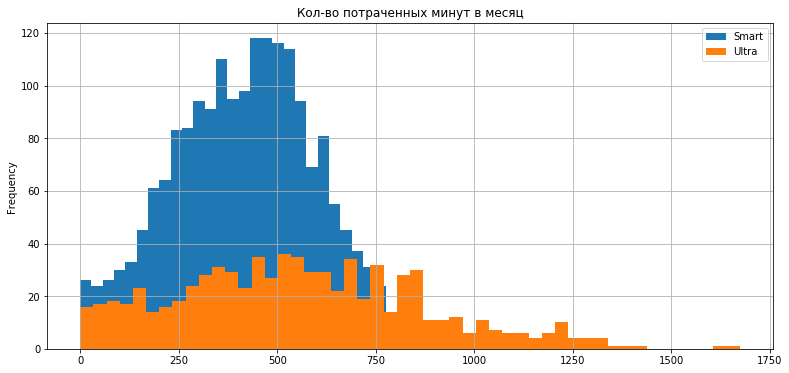

tariff,smart,ultra
count,1914.000000,751.000000
mean,421.232497,557.456724
std,187.562717,311.637452
min,0.000000,0.000000
25%,288.000000,332.500000
50%,427.000000,538.000000
75%,547.000000,760.500000
max,1435.000000,1673.000000


In [ ]:
info_traffic(smart_data, 'rounded_duration_per_month', 'Кол-во потраченных минут в месяц')
info_traffic(ultra_data, 'rounded_duration_per_month', 'Кол-во потраченных минут в месяц')
plt.show()
discribe_parameter('rounded_duration_per_month')

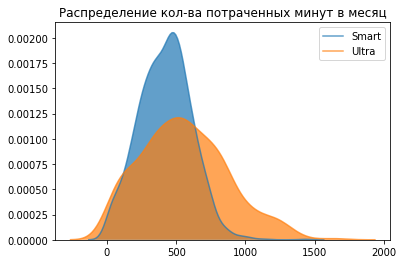

In [ ]:
displot_traffic(smart_data, 'rounded_duration_per_month', 'Распределение кол-ва потраченных минут в месяц')
displot_traffic(ultra_data, 'rounded_duration_per_month', 'Распределение кол-ва потраченных минут в месяц')
plt.show()

* Распределения по обоим тарифам близки к нормальным.
* Клиенты с тарифом Ultra ежемесячно в среднем дольше говорят по телефону, чем пользователи Smart (557 и 421 минута соответственно).
* Распределение тарифа Ultra намного шире, что подтверждается большим значением дисперсии в сравнении с тарифом Smart.
* Медианы для обоих тарифных планов почти совпадают со средними значениями. Значит, выбросов в выборке немного.

### Кол-во отправленных сообщений в месяц на двух тарифах

Тариф: SMART
Параметр: Кол-во отправленных сообщений в месяц
среднее значение: 38.79
значение дисперсии: 718.43
значение стандартного отклонения: 26.8

Тариф: ULTRA
Параметр: Кол-во отправленных сообщений в месяц
среднее значение: 61.72
значение дисперсии: 2006.64
значение стандартного отклонения: 44.8



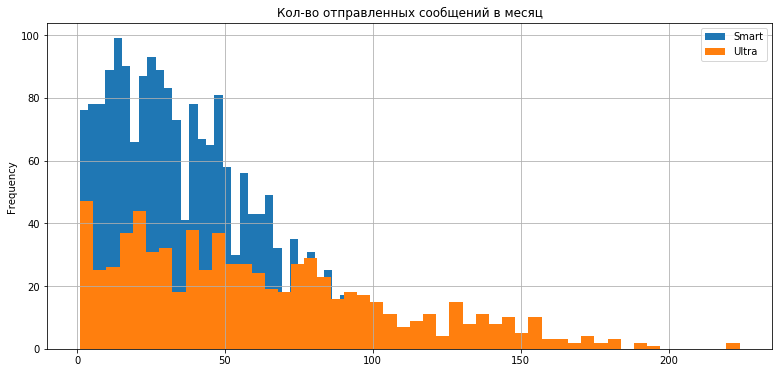

tariff,smart,ultra
count,1914.000000,751.000000
mean,38.786834,61.719041
std,26.803607,44.795502
min,1.000000,1.000000
25%,17.000000,25.000000
50%,34.000000,53.000000
75%,55.000000,89.000000
max,143.000000,224.000000


In [ ]:
info_traffic(smart_data, 'messages_per_month', 'Кол-во отправленных сообщений в месяц')
info_traffic(ultra_data, 'messages_per_month', 'Кол-во отправленных сообщений в месяц')
plt.show()
discribe_parameter('messages_per_month')

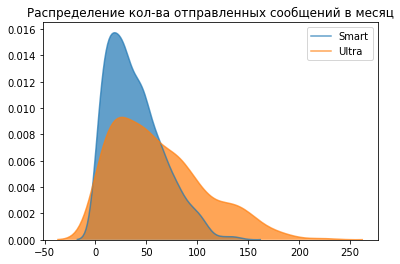

In [ ]:
displot_traffic(smart_data, 'messages_per_month', 'Распределение кол-ва отправленных сообщений в месяц')
displot_traffic(ultra_data, 'messages_per_month', 'Распределение кол-ва отправленных сообщений в месяц')
plt.show()

* Распределения по обоим тарифам близки к Пуассоновским.
* Клиенты с тарифом Ultra ежемесячно в среднем отправляют большше смс, чем пользователи Smart (61 и 38 сообщений соответственно).
* Распределение тарифа Ultra намного шире, что подтверждается большим значением дисперсии в сравнении с тарифом Smart.
* Медианы для обоих тарифных планов почти совпадают со средними значениями. Значит, выбросов в выборке немного.

### Кол-во потраченных мегабайт в месяц на двух тарифах

Тариф: SMART
Параметр: Кол-во потраченных мегабайт в месяц
среднее значение: 16253.73
значение дисперсии: 33438470.06
значение стандартного отклонения: 5782.6

Тариф: ULTRA
Параметр: Кол-во потраченных мегабайт в месяц
среднее значение: 19622.44
значение дисперсии: 92338984.5
значение стандартного отклонения: 9609.32



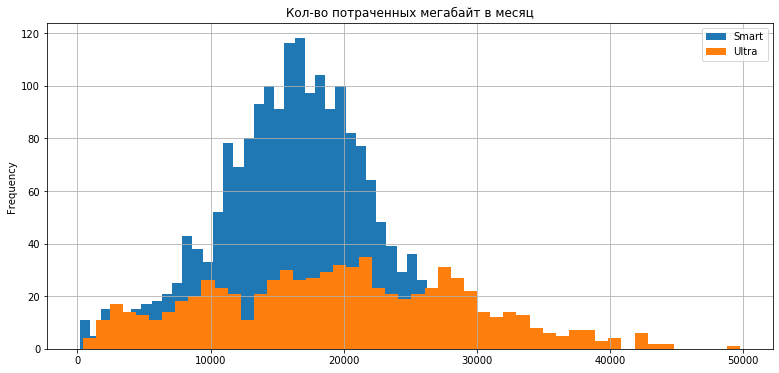

tariff,smart,ultra
count,1914.000000,751.000000
mean,16253.730104,19622.442197
std,5782.600631,9609.317588
min,201.070000,439.610000
25%,12630.035000,12009.595000
50%,16462.420000,19446.140000
75%,20045.517500,26834.460000
max,38552.450000,49745.690000


In [ ]:
info_traffic(smart_data, 'mb_used_per_month', 'Кол-во потраченных мегабайт в месяц')
info_traffic(ultra_data, 'mb_used_per_month', 'Кол-во потраченных мегабайт в месяц')
plt.show()
discribe_parameter('mb_used_per_month')

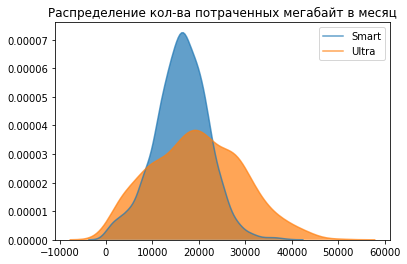

In [ ]:
displot_traffic(smart_data, 'mb_used_per_month', 'Распределение кол-ва потраченных мегабайт в месяц')
displot_traffic(ultra_data, 'mb_used_per_month', 'Распределение кол-ва потраченных мегабайт в месяц')
plt.show()

* Распределения по обоим тарифам близки к нормальным.
* Клиенты с тарифом Ultra ежемесячно в среднем тратят больше мегабайт, чем пользователи Smart (19622 и 16253 мегабайт соответственно).
* Распределение тарифа Ultra намного шире, что подтверждается большим значением дисперсии в сравнении с тарифом Smart.
* Медианы для обоих тарифных планов почти совпадают со средними значениями. Значит, выбросов в выборке немного.

### Прибыль двух тарифов в месяц

Тариф: SMART
Параметр: Прибыль тарифа в месяц
среднее значение: 1291.06
значение дисперсии: 677119.56
значение стандартного отклонения: 822.87

Тариф: ULTRA
Параметр: Прибыль тарифа в месяц
среднее значение: 2049.07
значение дисперсии: 110952.46
значение стандартного отклонения: 333.1



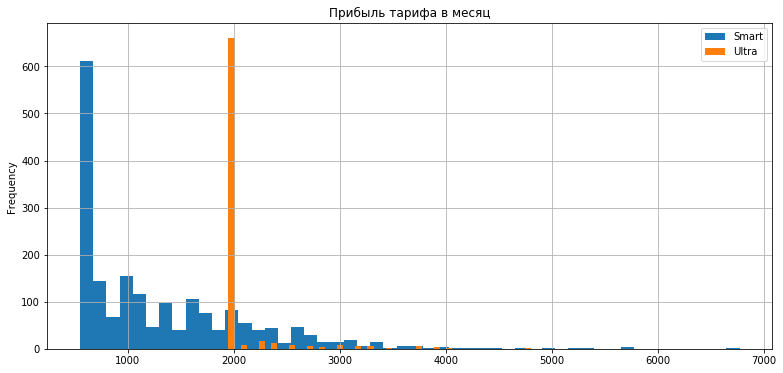

tariff,smart,ultra
count,1914.000000,751.000000
mean,1291.064786,2049.067909
std,822.872751,333.095277
min,550.000000,1950.000000
25%,553.750000,1950.000000
50%,1012.500000,1950.000000
75%,1750.000000,1950.000000
max,6770.000000,4800.000000


In [ ]:
info_traffic(smart_data, 'month_income', 'Прибыль тарифа в месяц')
info_traffic(ultra_data, 'month_income', 'Прибыль тарифа в месяц')
plt.show()
discribe_parameter('month_income')

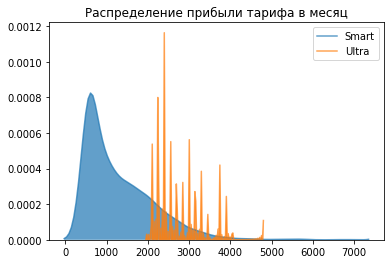

In [ ]:
displot_traffic(smart_data, 'month_income', 'Распределение прибыли тарифа в месяц')
displot_traffic(ultra_data, 'month_income', 'Распределение прибыли тарифа в месяц')
plt.show()

* Распределение тарифа Smart близко к Пуассоновскому.
* На гистограмме выдны пики - это те коиенты, которые не превысили лимиты тарифов и заплатили лишь абонентскую плату
* Распределение тарифа Smart намного шире, что подтверждается большим значением дисперсии в сравнении с тарифом Ultra.

### Вывод по этапу



Потребление разного вида трафика у пользователей тарифа Ultra в среднем больше, чем у пользователей тарифа Smart:

* Среднее количество звонков/мес пользователей Ultra больше, чем у пользователей Smart.
* Пользователи Ultra ежемесячно в среднем дольше говорят по телефону, чем пользователи Smart.
* Пользователи тарифа Ultra в среднем отправляют больше sms в месяц, чем пользователи тарифа Smart.
* В среднем пользователи Ultra ежемесячно потребляют больше трафика, чем пользователи Smart.

Значение дисперсии разных видов трафика по тарифу Ultra больше, чем по тарифу Smart.

## Проверка гипотез

### Проверка гипотезы: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

* Нулевая гипотеза (H0) - Средняя выручка пользователей тарифа Ultra не отличается от средней выручки пользователей тарифа Smart.
* Альтернативная гипотеза (H1) - средняя выручка пользователей тарифа Ultra отличается от средней выручки пользователей тарифа Smart.

Проверим нулевую гипотезу о равенстве средних значений двух выборок:

In [ ]:
alpha = 0.01
results = st.ttest_ind(smart_data['month_income'].to_list(), ultra_data['month_income'].to_list())

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.974564069988222e-119
Отвергаем нулевую гипотезу


Средняя выручка пользователей тарифа *Ultra* **отличается** от средней выручки пользователей тарифа *Smart*.

### Проверка гипотезы: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для того, чтобы проверить гипотезу, создадим 2 датасета: 1 с клиентами из Москвы, 2 с клиентами из других городов:

In [ ]:
moscow_data = merged_data.query('city == "Москва"')

In [ ]:
no_moscow_data = merged_data.query('city != "Москва"')

In [ ]:
moscow_data.shape[0] + no_moscow_data.shape[0] == merged_data.shape[0]

True

Сгруппируем выручку по столбцу *user_id*:

In [ ]:
moscow_data = moscow_data.groupby('user_id')['month_income'].agg('mean')
moscow_data = moscow_data.reset_index()
moscow_data.describe()

,user_id,month_income
count,82.000000,82.000000
mean,1263.902439,1522.788215
std,142.628899,656.684902
min,1003.000000,550.000000
25%,1146.500000,995.000000
50%,1284.500000,1597.616071
75%,1384.000000,1950.000000
max,1490.000000,3233.000000


In [ ]:
no_moscow_data = no_moscow_data.groupby('user_id')['month_income'].agg('mean')
no_moscow_data = no_moscow_data.reset_index() 
no_moscow_data.describe()

,user_id,month_income
count,337.000000,337.000000
mean,1248.931751,1552.830963
std,146.635333,675.332322
min,1000.000000,550.000000
25%,1125.000000,983.600000
50%,1251.000000,1570.600000
75%,1378.000000,1950.000000
max,1499.000000,5252.000000


* Нулевая гипотеза (H0) - Средняя выручка пользователей из Москвы не отличается от средней выручки пользователей из других городов.
* Альтернативная гипотеза (H1) - Средняя выручка пользователей из Москвы отличается от средней выручки пользователей из других городов.

In [ ]:
alpha = 0.05
results = st.ttest_ind(moscow_data['month_income'].to_list(), no_moscow_data['month_income'].to_list())

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.7166391729368358
Не получилось отвергнуть нулевую гипотезу


Средняя выручка пользователей из Москвы не отличается от средней выручки пользователей из других городов.

Найдем среднюю выручку в москве и в регионах:

In [ ]:
print('Средняя выручка пользователя в месяц в Москве:', moscow_data['month_income'].mean())
print('Средняя выручка пользователя в месяц в регионах:', no_moscow_data['month_income'].mean())

Средняя выручка пользователя в месяц в Москве: 1522.7882153415687
Средняя выручка пользователя в месяц в регионах: 1552.8309631927584


Средняя выручка в Москве и в регионах отличается всего на 30 рублей.

## Общий вывод

Были проанализированы все показатели активности пользователей обоих тарифных планов. В ходе исследования было обнаружено, что в среднем клиенты тарифа Smart потребляют меньше трафика (звонки/sms/мегабайт), чем клиенты тарифа Ultra. Клиенты тарифа Smart и платят в среднем меньше, чем клиенты тарифа Ultra, но чаще превышают лимиты, установленные тарифом.

Для оператора с точки зрения потребления и выручки по тарифным планам, тариф Ultra выгоднее. 